In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import train_parameters, tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph

# Planning:

- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset


### BUGS:
- urgent: logdet calculation gives Nans, current fix: replace the zeros by eye in the sparse add, does not solve it in any case however

-> try: does it work with decomp and I stabilizer?

- m and S values go to infinity if inducing_point_res >= 9


### TODOS:

- Check T region definition (currently limits of inducing points)
- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

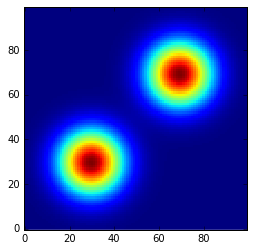

In [3]:
res = 100

Tmin = 0
Tmax = 10

xx, yy = np.meshgrid(np.linspace(Tmin, Tmax, res), np.linspace(Tmin, Tmax, res))

X = np.array([xx, yy]).transpose(1,2,0).reshape(res**2, 2)
vals = double_blob(X).reshape(res,res)

plt.imshow(vals, interpolation='none', origin='lower')
plt.show()

In [4]:
samples, _, _, _, _, _ = get_scp_samples(double_blob, np.array([[Tmin, Tmax], [Tmin,Tmax]]), 10)

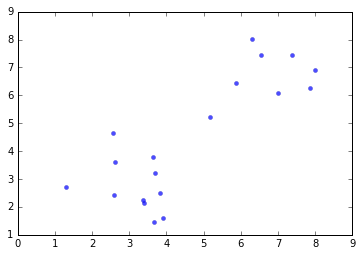

In [5]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

### 2D Parameter Learning

def train_parameters(res_inducing_points, alpha_init, data, train_hyperparameters=False):
    ## ######## ##
    # PARAMETERS #
    ## ######## ##
    log_dir        = 'logs'
    max_iterations = 1000
    ind_point_res  = res_inducing_points
    learning_rate  =0.001
    g_init = 0.3

    run_prefix = '2d_dummy_{}ipres_lr{}_{}iterations'.format(ind_point_res, learning_rate, max_iterations)

    # inducing point location
    Zx = np.linspace(1, 9, ind_point_res)[:,na]
    Zy = np.linspace(1, 9, ind_point_res)[:,na]

    xx_ind_points, yy_ind_points = np.meshgrid(Zx, Zy)

    Z = np.array([xx_ind_points, yy_ind_points]).transpose(1,2,0).reshape(ind_point_res**2, 2)

    # X = np.random.rand(10,2)*10

    ## ######### ##
    # BUILD GRAPH #
    ## ######### ##
    tf.reset_default_graph()
    lower_bound, merged, Z_ph, u_ph, X_ph, m, S,L_vech, interesting_gradient, K_zz_inv, alphas, gamma, Kzz = build_graph(Z.shape[0],Z.shape[1],alpha_init,g_init)

    variables = [m,L_vech]
    
    if train_hyperparameters:
        variables = variables + [alphas, gamma]
    
    with tf.name_scope('optimization'):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(-lower_bound,var_list=variables)


    #inspected_op = tf.get_default_graph().get_tensor_by_name("KL-divergence/truediv:0")
    #interesting_gradient = tf.gradients(lower_bound, [inspected_op])[0]

    with tf.name_scope('nanchecks'):
        check = tf.add_check_numerics_ops()

    ## ########## ##
    # OPTIMIZATION #
    ## ########## ##
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter(log_dir + '/' + run_prefix, sess.graph)

        S_init_val = sess.run([S])
        # print(S_init_val)
        # print(np.all(np.linalg.eigvals(S_init_val) >= 0))

        for i in range(max_iterations):
            _, lower_bound_val, m_val, S_val, grad_val, summary, Kzz_inv, _, alphas_vals, gamma_val, Kzz_val = sess.run([train_step, lower_bound, m, S, interesting_gradient, merged, K_zz_inv, check, alphas, gamma, Kzz], feed_dict={Z_ph:Z, u_ph:0.,X_ph:data})
            writer.add_summary(summary, i)

            # print(Kzz_val)
            # print('------------')
            #print(lower_bound_val)
            #print(Kzz_val)
            #print(g_val)
            # print(np.min(S_val))
            # print(np.max(S_val))
            # print(np.allclose(S_val, S_val.T))
            # print(np.all(np.linalg.eigvals(S_val) >= 0))

            #print(sess.run([S]))
            #print(sess.run([L_vech_grad]))
            
    
    return m_val, S_val, Kzz_inv, alphas_vals, Z, gamma_val

#### 2D Evaluation

In [6]:
def evaluation(m_val,S_val,Kzz_inv,alphas_vals,gamma_val,Z,eval_grid):
    #build graph
    lam, lam_var, Z_ph,X_eval_ph, K_zz_inv_ph, S_ph, m_ph,alphas_ph,gamma_ph  = build_eval_graph()

    #run session
    with tf.Session() as sess:
        lam_vals, = sess.run([lam], feed_dict={Z_ph:Z, X_eval_ph:eval_grid, K_zz_inv_ph: Kzz_inv, S_ph:S_val, m_ph:m_val, alphas_ph:alphas_vals, gamma_ph:gamma_val})

    return lam_vals


#### Evaluation with learned alphas and increasing number of inducing points

number inducing points:  3
alphas:  [ 1.  1.]
gamma:  0.3


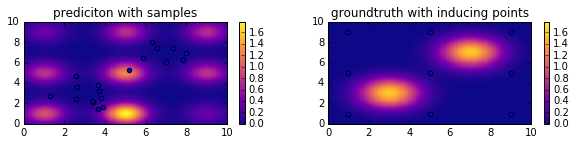

number inducing points:  4
alphas:  [ 1.  1.]
gamma:  0.3


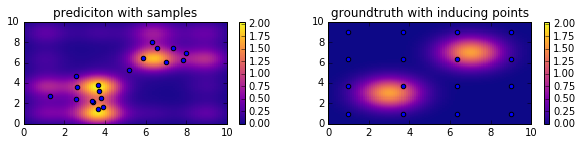

In [8]:
train_hyperparameters = False

#evaluation grid
eval_res = 100
eval_x = np.linspace(Tmin, Tmax, eval_res)[:,na]
eval_y = np.linspace(Tmin, Tmax, eval_res)[:,na]
xx_eval, yy_eval = np.meshgrid(eval_x, eval_y)
eval_grid = np.array([xx_eval, yy_eval]).transpose(1,2,0).reshape(eval_res**2, 2)

ind_point_nums = [3, 4]

counter = 1
for i in ind_point_nums: 
    
    m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt = train_parameters(samples, i, train_hyperparameters=train_hyperparameters)
    lam_vals = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt,eval_grid)

    #plots
    cmap = plt.get_cmap('plasma')

    fig = plt.figure(figsize=(10,15)) 

    max_value = np.max([np.max(vals), np.max(lam_vals)])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

    print("ind point number: ",i)
    print("alphas: ",alphas_opt)
    print("gamma: ",gamma_opt)
    ax0 = ax0 = plt.subplot(7,2,counter)
    im = ax0.pcolormesh(xx_eval, yy_eval, lam_vals.reshape(eval_res,eval_res), cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('prediciton with samples')
    ax0.scatter(samples[:,0], samples[:,1])
    plt.xlim(Tmin, Tmax)
    plt.ylim(Tmin, Tmax)

    ax1 = ax0 = plt.subplot(7,2,counter+1)
    im1 = ax1.pcolormesh(xx, yy, vals, cmap=cmap,norm=norm)
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('groundtruth with inducing points')
    ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
    plt.xlim(Tmin, Tmax)
    plt.ylim(Tmin, Tmax)
    counter += 2
    #plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
    plt.show()